📌 데이터 샘플:
        Date Origin Destination Airline    Price
0 2025-04-13    ICN         LHR   루프트한자  1263800
1 2025-04-13    ICN         LHR     KLM  1264900
2 2025-04-13    ICN         LHR   에어프랑스  1336400
3 2025-04-13    ICN         LHR  아시아나항공  1596800
4 2025-04-14    ICN         LHR   루프트한자  1151400

📌 결측값 확인:
Date           0
Origin         0
Destination    0
Airline        0
Price          0
dtype: int64


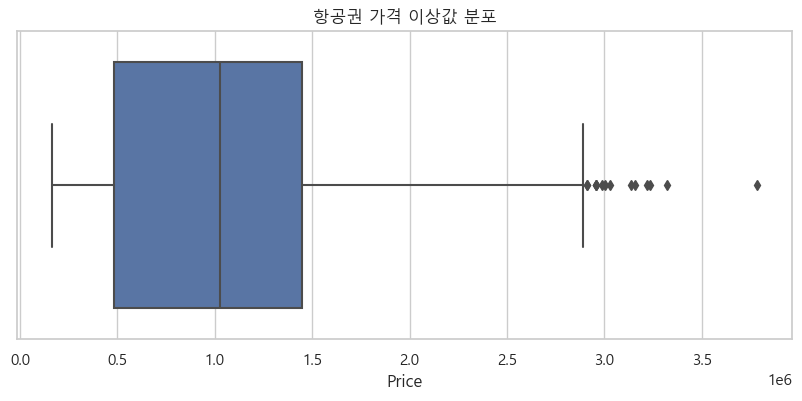

Fitting 3 folds for each of 108 candidates, totalling 324 fits

🎯 모델 성능 비교
[Linear Regression] MAE: 472220.23, RMSE: 537859.55
[XGBoost (Tuned)] MAE: 122080.68, RMSE: 199488.61
[Ensemble Model] MAE: 271812.39, RMSE: 323196.33


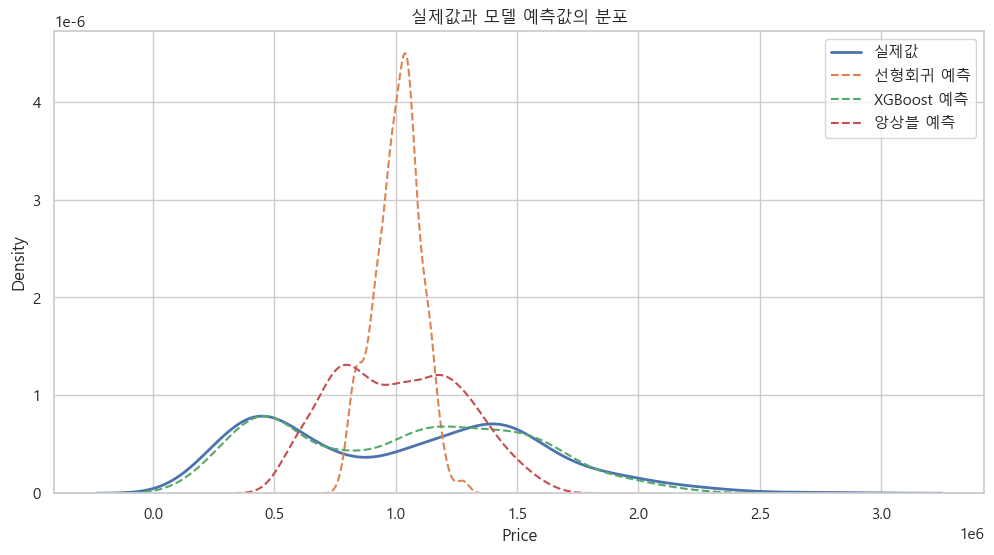

 95%|=================== | 4383/4625 [00:17<00:00]       

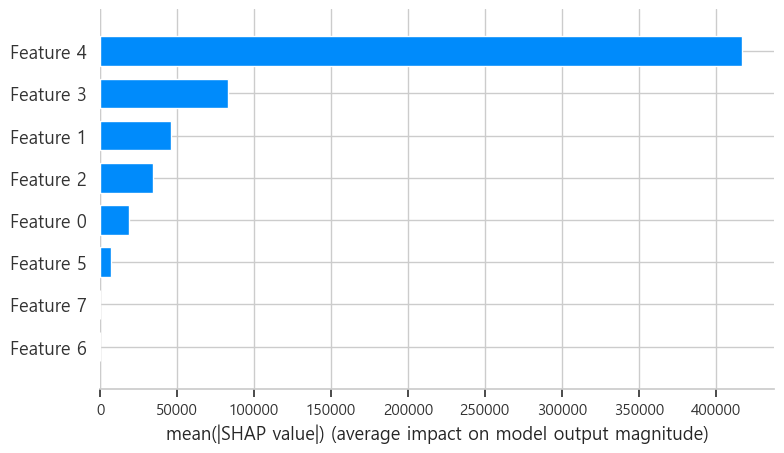

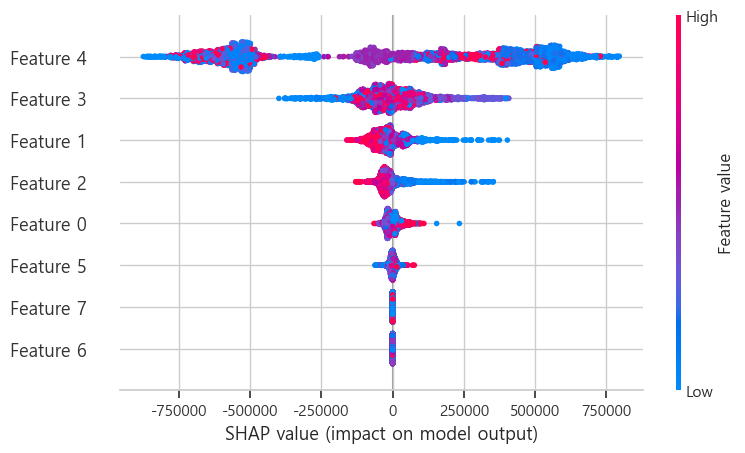

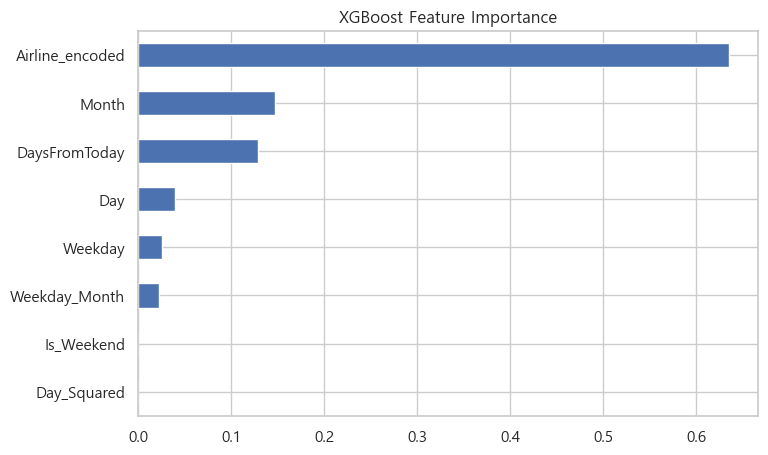

In [11]:
# =============================
# 1. 라이브러리 불러오기
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import shap
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우
# mpl.rcParams['font.family'] = 'AppleGothic'  # macOS의 경우

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# =============================
# 2. 데이터 불러오기 및 기본 확인
# =============================
# ICN - LHR 항공권 데이터
df_lhr = pd.read_csv("flights_all_ICN_LHR_2025-04-13_2025-12-31.csv")

# ICN - LAX 항공권 데이터
df_lax = pd.read_csv("flights_all_ICN_LAX_2025-04-13_2026-03-31.csv")

# ICN - HND 항공권 데이터
df_hnd = pd.read_csv("flights_all_ICN_HND_2025-04-13_2026-03-31.csv")

# ICN - NRT 항공권 데이터
df_nrt = pd.read_csv("flights_all_ICN_NRT_2025-04-13_2026-03-31.csv")

# ICN - SEA 항공권 데이터
df_sea = pd.read_csv("flights_all_ICN_SEA_2025-04-13_2026-03-31.csv")

# DataFrame 통합
df = pd.concat([df_lhr, df_lax, df_hnd, df_nrt, df_sea], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])

print("📌 데이터 샘플:")
print(df.head())

print("\n📌 결측값 확인:")
print(df.isnull().sum())

# =============================
# 3. 파생변수 생성
# =============================
today = pd.to_datetime("today").normalize()
df['Weekday'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DaysFromToday'] = (df['Date'] - today).dt.days

# =============================
# 4. 범주형 변수 인코딩
# =============================
le = LabelEncoder()
df['Airline_encoded'] = le.fit_transform(df['Airline'])

# =============================
# 5. 이상값 탐지 및 시각화
# =============================
plt.figure(figsize=(10,4))
sns.boxplot(x=df['Price'])
plt.title("항공권 가격 이상값 분포")
plt.show()

# (선택적) 이상값 제거
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# =============================
# 6. 최종 피처 구성
# =============================
df['Weekday_Month'] = df['Weekday'] * df['Month']
df['Day_Squared'] = df['Day'] ** 2
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

features = ['Weekday', 'Month', 'Day', 'DaysFromToday', 'Airline_encoded', 'Weekday_Month', 'Day_Squared', 'Is_Weekend']
X = df[features]
y = df['Price']

# =============================
# 6. 데이터스케일링
# =============================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# =============================
# 7. 모델 학습 - 선형 회귀
# =============================
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# =============================
# 8. 모델 학습 - XGBoost 회귀
# =============================
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
xgb_preds_tuned = best_xgb_model.predict(X_test)

# =============================
# 9. 앙상블 모델 학습
# =============================

ensemble_model = VotingRegressor([('lr', lr_model), ('xgb', best_xgb_model)])
ensemble_model.fit(X_train, y_train)
ensemble_preds = ensemble_model.predict(X_test)


# =============================
# 9. 성능 비교 지표 출력
# =============================
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"[{name}] MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print("\n🎯 모델 성능 비교")
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("XGBoost (Tuned)", y_test, xgb_preds_tuned)
evaluate_model("Ensemble Model", y_test, ensemble_preds)

# =============================
# 10. 실제값 vs 예측값 시각화
# =============================
plt.figure(figsize=(12, 6))
sns.kdeplot(y_test, label='실제값', linewidth=2)
sns.kdeplot(lr_preds, label='선형회귀 예측', linestyle='--')
sns.kdeplot(xgb_preds_tuned, label='XGBoost 예측', linestyle='--')
sns.kdeplot(ensemble_preds, label='앙상블 예측', linestyle='--')
plt.title("실제값과 모델 예측값의 분포")
plt.legend()
plt.show()

# =============================
# 11. SHAP 해석
# =============================
explainer = shap.Explainer(best_xgb_model, X_train)  # 모델과 데이터를 전달
shap_values = explainer(X_train)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train, plot_type='bar')

# SHAP Detailed Summary
shap.summary_plot(shap_values, X_train)

# SHAP Force Plot (특정 샘플)
sample_idx = 10
shap.plots.force(shap_values[sample_idx], X_train[sample_idx])

# Feature Importance 시각화
importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns)
importances = importances.sort_values()

plt.figure(figsize=(8, 5))
importances.plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.show()